# Live Coding
## Week 10 Clustering Data

__Outline__
>T1 - Libraries & setup  
T2 - Loading data - Polygons & Points
T3 - Summarise data by area   
T4 - Scale data frame - Standardization & Rescale  
T5 - Clustering  

In [1]:
# Libraries and modules
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os

from matplotlib.colors import ListedColormap

# All of these are potentially useful, though
# not all have been used in this practical --
# I'd suggest exploring the use of different 
# Scalers/Transformers as well as clustering 
# algorithms...
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

In [2]:
# load MSOA data
# You should have this locally...
msoas = gpd.read_file(os.path.join('data','MSOAs.gpkg'), driver='GPKG')

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [3]:
msoas.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   MSOA11CD   983 non-null    object  
 1   MSOA11NM   983 non-null    object  
 2   LAD11CD    983 non-null    object  
 3   LAD11NM    983 non-null    object  
 4   RGN11CD    983 non-null    object  
 5   RGN11NM    983 non-null    object  
 6   USUALRES   983 non-null    int64   
 7   HHOLDRES   983 non-null    int64   
 8   COMESTRES  983 non-null    int64   
 9   POPDEN     983 non-null    float64 
 10  HHOLDS     983 non-null    int64   
 11  AVHHOLDSZ  983 non-null    float64 
 12  geometry   983 non-null    geometry
dtypes: float64(2), geometry(1), int64(4), object(6)
memory usage: 100.0+ KB


In [4]:
# Boroughs GeoPackage
b_path = os.path.join('data','Boroughs.gpkg')
if not os.path.exists(b_path):
    boros = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Boroughs.gpkg?raw=true')
    boros.to_file(b_path)
    print("Downloaded Boroughs.gpkg file.")
else:
    boros = gpd.read_file(b_path)

In [5]:
# load listings data
# feel free to load your local copy rather than loading via the URL:
url = 'https://github.com/jreades/i2p/blob/master/data/clean/2020-08-24-listings.csv.gz?raw=true'
df = pd.read_csv(url, compression='gzip', low_memory=False, 
                 usecols=['room_type','longitude','latitude','price'])
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Data frame is 74,120 x 4


In [6]:
# create geodataframe
gdf = gpd.GeoDataFrame(df, 
      geometry=gpd.points_from_xy(df['longitude'], df['latitude'], crs='epsg:4326'))
gdf = gdf.to_crs('epsg:27700')

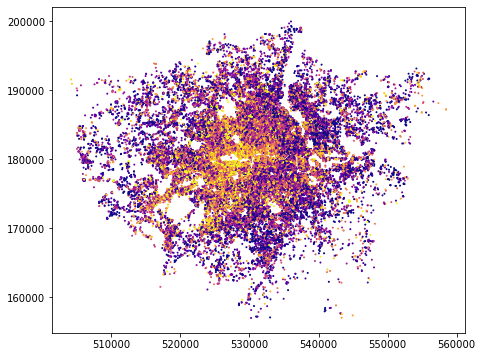

In [7]:
# plot listings
gdf.plot(column='price', cmap='plasma', scheme='quantiles', k=10, markersize=1, figsize=(8,6));

(180000.0, 188000.0)

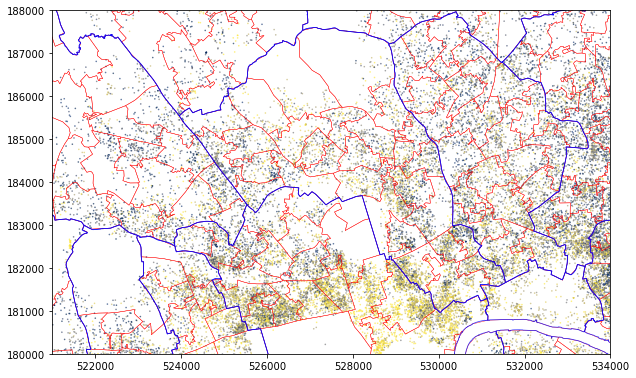

In [8]:
# plot listings and MSOAs, zoom in
# MSOA: 5,000-15,000 population, 2,000-6,000 households
f,ax=plt.subplots(figsize=(10,7))
gdf.plot(ax=ax, column='price', scheme='quantiles',  k=10, cmap='cividis', alpha=0.6, markersize=0.4)
msoas.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=0.4, alpha=0.95)
boros.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=0.8, alpha=0.75)
ax.set_xlim([521000, 534000])
ax.set_ylim([180000, 188000])

In [9]:
# Aggregate Listings by MSOA
# ml == MSOA Listings
ml = gpd.sjoin(gdf, msoas, op='within').drop(columns=['latitude','longitude'])

In [10]:
ml.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 74080 entries, 0 to 73335
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   room_type    74080 non-null  object  
 1   price        74080 non-null  float64 
 2   geometry     74080 non-null  geometry
 3   index_right  74080 non-null  int64   
 4   MSOA11CD     74080 non-null  object  
 5   MSOA11NM     74080 non-null  object  
 6   LAD11CD      74080 non-null  object  
 7   LAD11NM      74080 non-null  object  
 8   RGN11CD      74080 non-null  object  
 9   RGN11NM      74080 non-null  object  
 10  USUALRES     74080 non-null  int64   
 11  HHOLDRES     74080 non-null  int64   
 12  COMESTRES    74080 non-null  int64   
 13  POPDEN       74080 non-null  float64 
 14  HHOLDS       74080 non-null  int64   
 15  AVHHOLDSZ    74080 non-null  float64 
dtypes: float64(3), geometry(1), int64(5), object(7)
memory usage: 9.6+ MB


In [11]:
# summarise by MSOA
# count by room type by MSOA
mlgc = ml.groupby(['MSOA11CD','room_type'])['price'].agg(Count='count').reset_index() # msoa listings grouped counts
mlgc.head()

,MSOA11CD,room_type,Count
0,E02000001,Entire home/apt,398
1,E02000001,Hotel room,4
2,E02000001,Private room,48
3,E02000001,Shared room,2
4,E02000002,Private room,10


In [12]:
# median price by MSOA
mlgp = ml.groupby('MSOA11CD')['price'].agg('median').reset_index() # msoa listings grouped price
mlgp.head()

,MSOA11CD,price
0,E02000001,125.00
1,E02000002,50.00
2,E02000003,40.00
3,E02000004,29.00
4,E02000005,69.00


In [13]:
# use of the pivot table function to generate counts by MSOA in 'wide' format
# drop columns we don't need
mlgc = mlgc.pivot(index='MSOA11CD', columns=['room_type'], values=['Count']).reset_index()
mlgc.columns = ['MSOA11CD','Entire home/apt','Hotel room','Private room','Shared room']
mlgc.drop(columns=['Hotel room','Shared room'], inplace=True)
mlgc.head()

,MSOA11CD,Entire home/apt,Private room
0,E02000001,398.00,48.00
1,E02000002,NaN,10.00
2,E02000003,5.00,19.00
3,E02000004,NaN,1.00
4,E02000005,3.00,9.00


In [14]:
# merge the grouped counts and price back to a mlg (MSOA Listings Grouped) data frame:
mlg = pd.merge(mlgc, mlgp, on='MSOA11CD')
mlg = mlg.fillna(0).set_index('MSOA11CD')
mlg.head()

,Entire home/apt,Private room,price
MSOA11CD,,,
E02000001,398.00,48.00,125.00
E02000002,0.00,10.00,50.00
E02000003,5.00,19.00,40.00
E02000004,0.00,1.00,29.00
E02000005,3.00,9.00,69.00


In [15]:
# scale data frame
# TRANSFORM (standardization)
# initialise transformer (from preprocessing module)
pts = PowerTransformer()
# transform column values
for c in mlg.columns.values:
    mlg[c] = pts.fit_transform(mlg[c].values.reshape(-1,1))
mlg.head()

,Entire home/apt,Private room,price
MSOA11CD,,,
E02000001,2.12,0.81,1.81
E02000002,-1.99,-0.77,-0.21
E02000003,-0.66,-0.16,-0.83
E02000004,-1.99,-2.30,-1.82
E02000005,-0.95,-0.86,0.58


In [16]:
# Load the Reduced Dimension Data from Week 9
rddf = gpd.read_file(os.path.join('data','Reduced_Dimension_Data.gpkg'), driver='GPKG').set_index('MSOA11CD')
rddf.drop(columns=['Subregion','geometry','Dimension 1','Dimension 2','MSOA11NM','LAD11CD','LAD11NM','RGN11CD',
                   'RGN11NM','USUALRES','HHOLDRES','COMESTRES','POPDEN','HHOLDS','AVHHOLDSZ'], inplace=True)
print(f"Reduced Dimensionality Data Frame is {rddf.shape[0]:,} x {rddf.shape[1]:,}")
rddf.head(2)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Reduced Dimensionality Data Frame is 983 x 10


,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10
MSOA11CD,,,,,,,,,,
E02000001,2.78,0.33,-0.46,-1.57,1.26,0.20,7.24,-0.93,-0.48,-1.08
E02000002,-1.18,-0.50,-0.49,-0.56,0.48,1.03,0.95,0.52,0.23,-0.34


In [17]:
# Merge the reducded dimensionality data frame with the msoa listings grouped data frame
cldf = pd.merge(rddf, mlg, left_index=True, right_index=True)

In [18]:
# geodataframe with MSOAs code and geometry
msoas1 = msoas.loc[:,['MSOA11CD','geometry']]

In [19]:
# RESCALE the columns using the MinMaxScaler set up in the Preamble
# initialise transformer (from preprocessing module)
mms = MinMaxScaler(feature_range=(-1,1))

for c in cldf.columns:
    cldf[c] = mms.fit_transform(cldf[c].values.reshape(-1,1))
    
# Check output
cldf.head(2)[['Component 1','Component 2','Component 3','price']]

,Component 1,Component 2,Component 3,price
MSOA11CD,,,,
E02000001,-0.08,-0.09,-0.25,0.25
E02000002,-0.90,-0.33,-0.25,-0.26


In [20]:
# create a 'result set' (rs) data frame with the MSOAs geometry
# to hold the results of the clustering operation
rs  = pd.merge(msoas1, cldf, left_on='MSOA11CD', right_index=True).set_index('MSOA11CD')

In [21]:
# kmeans clustering
c_nm   = 'KMeans' # Clustering name
k_pref = 3 # Number of clusters

kmeans = KMeans(n_clusters=k_pref, n_init=25, random_state=42).fit(cldf) # The process

In [22]:
# The results
print(kmeans.labels_)

[0 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 1 2 1 1 2 1 2 2 2 1 2 1 1 1 1 1 2 2 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 2 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 1 2 2 1 2 1 1 1 1 0 2 1 0 1 1 2 0
 0 1 1 2 1 0 1 0 0 0 0 0 2 2 1 1 1 2 1 1 2 2 2 1 2 1 2 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 2 0 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 1 2 2 2 1 1 1 2 2 1 2 1 2 0 1 2 1 1 0 1 1 2 0 0 2 1 1 1 1
 1 1 1 0 1 2 2 1 2 2 1 2 2 2 2 2 2 2 2 1 2 1 1 1 2 1 1 1 2 2 1 2 1 2 1 1 1
 1 2 1 1 1 1 2 1 1 0 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 2 2 2 1 2 1 2 2 1 1 1 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0
 1 1 0 1 1 0 1 0 2 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 1 1 2 1 1 2 1 2 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 1 1 2 2 2 2 2 1 

In [23]:
# Add it to the data frame
rs[c_nm] = pd.Series(kmeans.labels_, index=cldf.index)

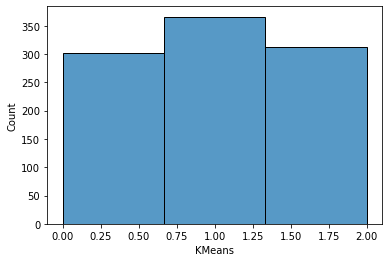

In [24]:
# How are the clusters distributed?
ax = sns.histplot(data=rs, x=c_nm, bins=k_pref);

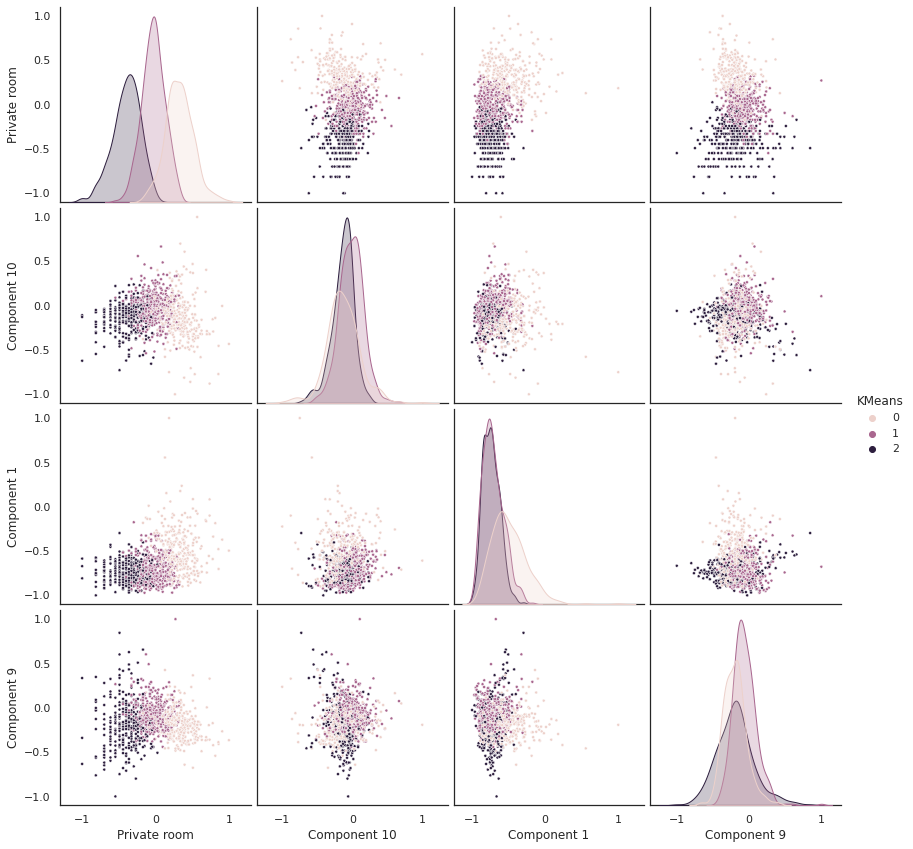

In [25]:
# Going to be a bit hard to read if 
# we plot every variable against every
# other variables, so we'll just pick a few
cols_to_plot = np.random.choice(cldf.columns.values, 4, replace=False)

# visualise results between pair of variables
sns.set(style="white")
sns.pairplot(rs, 
             vars=cols_to_plot, 
             hue=c_nm, markers=".", height=3, diag_kind='kde');

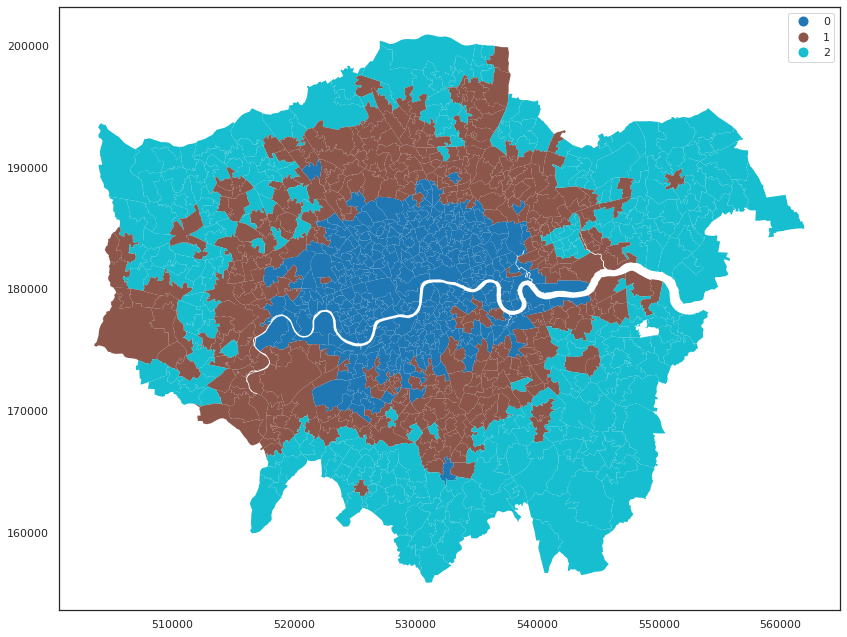

In [26]:
# plot map
fig, ax = plt.subplots(1, figsize=(14, 12))
rs.plot(column=c_nm, ax=ax, linewidth=0, zorder=0, categorical=True, legend=True);